In [91]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Data Preprocessing

In [15]:
profile_spec_path = './logs/profiles_eval/'
performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            spec_num = file.split('_')[-1]
            outputs = []
            for performance_mat in performance_metrics:
                performance_path = os.path.join(root,performance_mat+spec_num)
                if os.path.exists(performance_path):
                    performance_df = pd.read_csv(performance_path)
                    performance_df =performance_df.fillna(0)
                    outputs.append(performance_df.copy())
            if outputs:
                file_path = os.path.join(root, file)
                spec_df = pd.read_csv(file_path)
                spec_df = spec_df.fillna(0)
                evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
                sample_index += 1

print(len(evtol_performance_data_dic))

95


In [21]:
# performance_metrics = ['profile_flight_conditions_','profile_aerodynamic_coefficients_', 
#                        'profile_aircraft_flight_speed_', 'profile_aircraft_electronics_',
#                       'profile_electric_motor_and_propeller_efficiencies_']

# performance_path = './logs/profiles_eval/'
# performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
#                        'profile_aerodynamic_coefficients_', 'profile_electric_motor_and_propeller_efficiencies_']
# performance_dfs = [None]*len(performance_metrics)

# for root, dirs, files in os.walk(profile_spec_path):
#     for file in files:
#         for i,p_metrics in enumerate(performance_metrics):
#             if p_metrics in file:
#                 file_path = os.path.join(root, file)
#                 performance_df = pd.read_csv(file_path)
#                 performance_df = performance_df.fillna(0)
#                 performance_dfs[i] = performance_df if performance_dfs[i] is None else \
#                                      pd.concat([performance_dfs[0], performance_df])
# for performance_df in performance_dfs:
#     print(performance_df.describe())


29.0

In [49]:
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]


In [66]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

In [67]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

(6965, 22)
(6965, 6)


0.016259998923139937


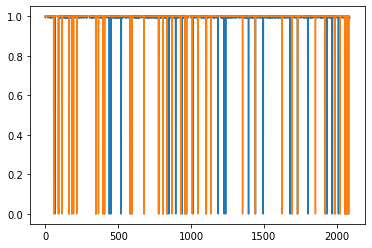

In [86]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, random_state=42)
regr_1 = DecisionTreeRegressor(max_depth=32)
regr_1.fit(X_train, y_train[:,5])
y_1 = regr_1.predict(X_test)
plt.plot(y_1)
plt.plot(y_test[:,5])
err1 = mean_squared_error(y_test[:,5],y_1)
print(err1)

In [16]:
# prepare dataset
X = []
Y = []

for i in range(mission_spec_df.shape[0]):
    row = mission_spec_df.iloc[0].to_numpy()
    segment_type = row[0]
    x1 = get_one_hot_encode_form(segment_type)
    x2 = row[1:].astype('float64')
    x = np.concatenate((x1,x2))
    X.append(x)

    y = performance_df[performance_df['mission_segment'] == segment_type].to_numpy()
    y = y[:,2:].astype('float64')
    y = y.flatten()
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
print(X.shape,Y.shape)
    

(33, 19) (33, 48)


In [24]:


# Create the dataset
rng = np.random.RandomState(1)


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng
)

regr_1.fit(X, Y[:,2])
regr_2.fit(X, Y[:,2])

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
# plt.figure()
# plt.scatter(X, y, c="k", label="training samples")
# plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
# plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
# plt.xlabel("data")
# plt.ylabel("target")
# plt.title("Boosted Decision Tree Regression")
# plt.legend()
# plt.show()

TypeError: list indices must be integers or slices, not tuple

In [18]:
y_2

array([-90., -90., -90., -90., -90., -90., -90., -90., -90., -90., -90.,
       -90., -90., -90., -90., -90., -90., -90., -90., -90., -90., -90.,
       -90., -90., -90., -90., -90., -90., -90., -90., -90., -90., -90.])

In [19]:
Y[0,:]

array([ 0.00000000e+00,  0.00000000e+00, -9.00000000e+01,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.00000000e+01,  0.00000000e+00,  5.80132647e-03,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.00000000e+01,  0.00000000e+00,
        2.20562820e-02,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.00000000e+01,  0.00000000e+00,  4.55453734e-02,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.00000000e+01,  0.00000000e+00,
        7.16162979e-02,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.00000000e+01,  0.00000000e+00,  9.51053892e-02,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.00000000e+01,  0.00000000e+00,
        1.11360345e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.00000000e+01,  0.00000000e+00,  1.17161671e-01,  1.00000000e+00])

In [159]:
performance_metrics = ['profile_flight_conditions_','profile_aerodynamic_coefficients_', 
                       'profile_aircraft_flight_speed_', 'profile_aircraft_electronics_',
                      'profile_electric_motor_and_propeller_efficiencies_']
sample_df = pd.read_csv('./logs/sampled_UTM_dataset.csv')
profile_ids = sample_df['agent_id']
num_files = 0

X = []
Y = []

for profile_id in profile_ids:
    profile_spec_file_path = './logs/profiles_eval/profile_spec_'+str(profile_id)+'.csv'
    performance_spec_file_path = './logs/profiles_eval/'+performance_metrics[0]+str(profile_id)+'.csv'
    if os.path.exists(profile_spec_file_path) and os.path.exists(performance_spec_file_path):
        num_files += 1

        # prepare dataset
        mission_spec_df = pd.read_csv(profile_spec_file_name)
        mission_spec_df = mission_spec_df.fillna(0)
        performance_df = pd.read_csv(performance_spec_file_path)
        performance_df = performance_df.fillna(0)
        print(performance_df.head())

        for i in range(mission_spec_df.shape[0]):
            row = mission_spec_df.iloc[0].to_numpy()
            segment_type = row[0]
            x1 = get_one_hot_encode_form(segment_type)
            x2 = row[1:].astype('float64')
            x = np.concatenate((x1,x2))
            X.append(x)

            y = performance_df[performance_df['mission_segment'] == segment_type].to_numpy()
            y = y[:,2:].astype('float64')
            y = y.flatten()
            Y.append(y)


       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       5.158389   
1  lift_and_cruse     hover_climb     2.475778       5.158389   
2  lift_and_cruse     hover_climb     9.412755       5.158389   
3  lift_and_cruse     hover_climb    19.436977       5.158389   
4  lift_and_cruse     hover_climb    30.563023       5.158389   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.005454        True  
2              0.0        0.0  0.020736        True  
3              0.0        0.0  0.042819        True  
4              0.0        0.0  0.067329        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       4.070622   
1  lift_and_cruse     hover_climb     2.475778       4.070622   
2  lift_and_cruse     hover_climb     9.412755       4.070622   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       4.666707   
1  lift_and_cruse     hover_climb     2.475778       4.666707   
2  lift_and_cruse     hover_climb     9.412755       4.666707   
3  lift_and_cruse     hover_climb    19.436977       4.666707   
4  lift_and_cruse     hover_climb    30.563023       4.666707   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.006029        True  
2              0.0        0.0  0.022920        True  
3              0.0        0.0  0.047330        True  
4              0.0        0.0  0.074422        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       5.154112   
1  lift_and_cruse     hover_climb     2.475778       5.154112   
2  lift_and_cruse     hover_climb     9.412755       5.154112   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       5.565642   
1  lift_and_cruse     hover_climb     2.475778       5.565642   
2  lift_and_cruse     hover_climb     9.412755       5.565642   
3  lift_and_cruse     hover_climb    19.436977       5.565642   
4  lift_and_cruse     hover_climb    30.563023       5.565642   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.005055        True  
2              0.0        0.0  0.019218        True  
3              0.0        0.0  0.039685        True  
4              0.0        0.0  0.062402        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       4.862398   
1  lift_and_cruse     hover_climb     2.475778       4.862398   
2  lift_and_cruse     hover_climb     9.412755       4.862398   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       5.210501   
1  lift_and_cruse     hover_climb     2.475778       5.210501   
2  lift_and_cruse     hover_climb     9.412755       5.210501   
3  lift_and_cruse     hover_climb    19.436977       5.210501   
4  lift_and_cruse     hover_climb    30.563023       5.210501   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.005399        True  
2              0.0        0.0  0.020528        True  
3              0.0        0.0  0.042390        True  
4              0.0        0.0  0.066655        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000        4.48998   
1  lift_and_cruse     hover_climb     2.475778        4.48998   
2  lift_and_cruse     hover_climb     9.412755        4.48998   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       4.918184   
1  lift_and_cruse     hover_climb     2.475778       4.918184   
2  lift_and_cruse     hover_climb     9.412755       4.918184   
3  lift_and_cruse     hover_climb    19.436977       4.918184   
4  lift_and_cruse     hover_climb    30.563023       4.918184   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.005720        True  
2              0.0        0.0  0.021748        True  
3              0.0        0.0  0.044910        True  
4              0.0        0.0  0.070617        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       5.316957   
1  lift_and_cruse     hover_climb     2.475778       5.316957   
2  lift_and_cruse     hover_climb     9.412755       5.316957   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000        5.27143   
1  lift_and_cruse     hover_climb     2.475778        5.27143   
2  lift_and_cruse     hover_climb     9.412755        5.27143   
3  lift_and_cruse     hover_climb    19.436977        5.27143   
4  lift_and_cruse     hover_climb    30.563023        5.27143   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.005337        True  
2              0.0        0.0  0.020291        True  
3              0.0        0.0  0.041900        True  
4              0.0        0.0  0.065885        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000        4.09239   
1  lift_and_cruse     hover_climb     2.475778        4.09239   
2  lift_and_cruse     hover_climb     9.412755        4.09239   
3  lift_and_cruse     hov

       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       3.998707   
1  lift_and_cruse     hover_climb     2.475778       3.998707   
2  lift_and_cruse     hover_climb     9.412755       3.998707   
3  lift_and_cruse     hover_climb    19.436977       3.998707   
4  lift_and_cruse     hover_climb    30.563023       3.998707   

   pitch_angle_deg  range_nmi  time_min  fesibility  
0              0.0        0.0  0.000000        True  
1              0.0        0.0  0.007036        True  
2              0.0        0.0  0.026749        True  
3              0.0        0.0  0.055237        True  
4              0.0        0.0  0.086855        True  
       eVTOL_type mission_segment  altitude_ft  air_speed_mph  \
0  lift_and_cruse     hover_climb     0.000000       4.281185   
1  lift_and_cruse     hover_climb     2.475778       4.281185   
2  lift_and_cruse     hover_climb     9.412755       4.281185   
3  lift_and_cruse     hov

In [160]:
X = np.array(X)
Y = np.array(Y)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [118]:
regr_1 = DecisionTreeRegressor(max_depth=32)
regr_1.fit(X_train, y_train[:,1])

DecisionTreeRegressor(max_depth=32)

In [119]:
regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng
)
regr_2.fit(X_train, y_train[:,1])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                  n_estimators=300,
                  random_state=RandomState(MT19937) at 0x13727D540)

In [120]:
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

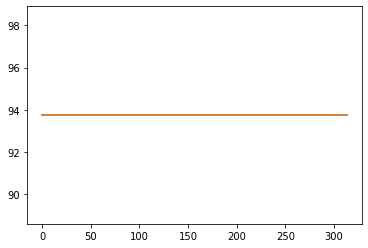

In [121]:
plt.plot(y_2)
plt.plot(y_test[:,1])

In [122]:
err1 = mean_squared_error(y_test[:,1],y_1)
err2 = mean_squared_error(y_test[:,1],y_2)
print(err1,err2)

0.0 0.0


In [123]:
err

308597781.54452044

0.0


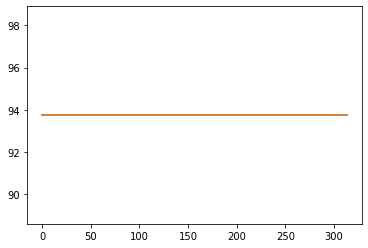

In [124]:
regr = svm.SVR()
regr.fit(X_train, y_train[:,1])
y_3 = regr.predict(X_test)
err3 = mean_squared_error(y_test[:,1],y_3)
print(err3)
plt.plot(y_3)
plt.plot(y_test[:,1])

0.0


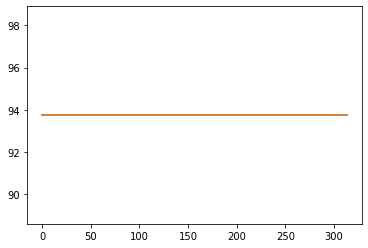

In [125]:
regr = LinearRegression()
regr.fit(X_train, y_train[:,1])
y_3 = regr.predict(X_test)
err3 = mean_squared_error(y_test[:,1],y_3)
print(err3)
plt.plot(y_3)
plt.plot(y_test[:,1])

In [162]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
print(X_train.shape,y_train.shape)

(731, 19) (731, 48)


In [164]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=19, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(48, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 512, epochs = 50, verbose=1)

Epoch 1/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0971
Epoch 2/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0965
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0959
Epoch 4/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0952
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0946
Epoch 6/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0939
Epoch 7/50
2/2 [==============================] - 0s 15ms/step - loss: 0.0933
Epoch 8/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0926
Epoch 9/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0919
Epoch 10/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0912
Epoch 11/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0905
Epoch 12/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0898
Epoch 13/50
2/2 [==============================] - 0s 7ms/step - loss:

In [165]:
X_test = scaler_x.transform(X_test)

In [166]:
y_pred = model.predict(X_test)

In [167]:
y_pred.shape

(314, 48)

In [168]:
y_test = scaler_y.transform(y_test)

In [169]:
err = mean_squared_error(y_pred,y_test)
print(err)

0.051276844874786696


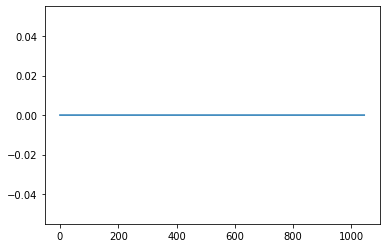

In [186]:
# plt.plot(y_pred[:,6])
# plt.plot(y_test[:,6])
plt.plot(Y[:,0])


# DecisionTreeRegressor

# # Flight Conditions

In [88]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)

(6965, 22)
(6965, 6)


In [122]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
for i in [0,1,2,5]:
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=False)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))


0.0
0.0174
0.0036
0.0206


# Aerodynamic Coefficients

In [123]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

(6965, 22)
(6965, 6)


In [125]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
for i in [0,1,2,3,5]:
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=False)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))

0.0
0.0
0.0016
0.0001
0.0204


# Aircraft Electronics

In [126]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

(6965, 22)
(6965, 11)


In [127]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
for i in [0,1,2,3,4,5,6,7,8,9,10]:
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=False)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))

0.0234
205.7168
0.1408
270.4525
227.1209
46.706
0.1069
0.1055
0.5629
122.2039
0.0206


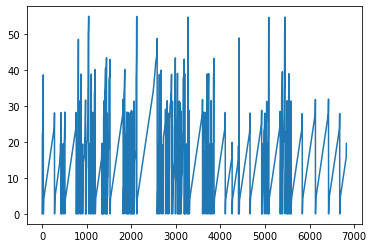

In [141]:
y = dataY[:,9]
indxes = dataY[:,-1]==1
y = y[indxes]
plt.plot(y)

# Electric motor and propeller efficiencies 

In [142]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

(6965, 22)
(6965, 18)


In [145]:
scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=False)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))

0.0013
0.0
4.216
13.0505
27.9826
0.0
0.0
0.0
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
122.3479
0.0


# AdaBoostRegressor

# GradientBoostingRegressor

# RandomForestRegressor

# SVM

# MLP

# LSTM